In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
from nltk.tokenize import word_tokenize

nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

[nltk_data] Downloading package stopwords to /home/bedge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bedge/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/bedge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [124]:
dataset = pd.read_csv("Dataset_clean.csv")
print(dataset.head())

                                                Text     Category
0  Changing the filter for your home s heating. v...  Health News
1  NASHVILLE. Tenn. (AP) — Tennessee s strict abo...  Health News
2  Work long enough. and you ll eventually face t...  Health News
3  AUSTIN. Texas (AP) — A Texas doctor said Thurs...  Health News
4  INDIANAPOLIS (AP) — An Indianapolis doctor who...  Health News


In [125]:
dataset.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [126]:
target_category = dataset['Category'].unique()
print(target_category)

['Health News' 'Politics News' 'Business News' 'Entertainment News']


In [127]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,Text,Category,CategoryId
0,Changing the filter for your home s heating. v...,Health News,0
1,NASHVILLE. Tenn. (AP) — Tennessee s strict abo...,Health News,0
2,Work long enough. and you ll eventually face t...,Health News,0
3,AUSTIN. Texas (AP) — A Texas doctor said Thurs...,Health News,0
4,INDIANAPOLIS (AP) — An Indianapolis doctor who...,Health News,0


In [128]:
# Create a new pandas dataframe "category", which only has unique Categories, also sorting this list in order of CategoryId values
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,Health News,0
211,Politics News,1
592,Business News,2
635,Entertainment News,3


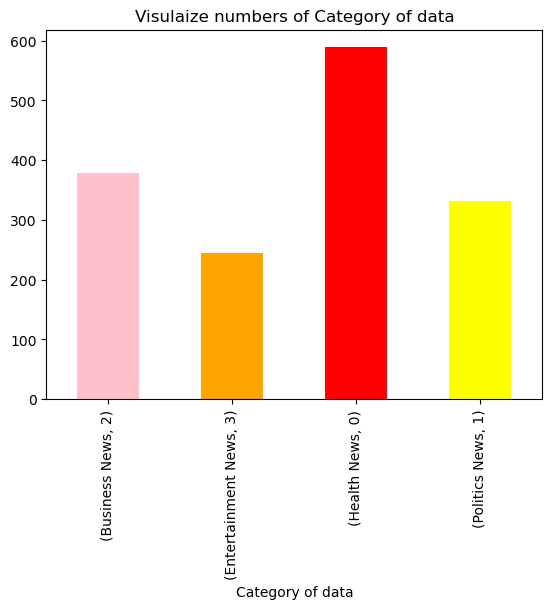

In [129]:
dataset.groupby('Category').CategoryId.value_counts().plot(kind="bar",
                                                           color=["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

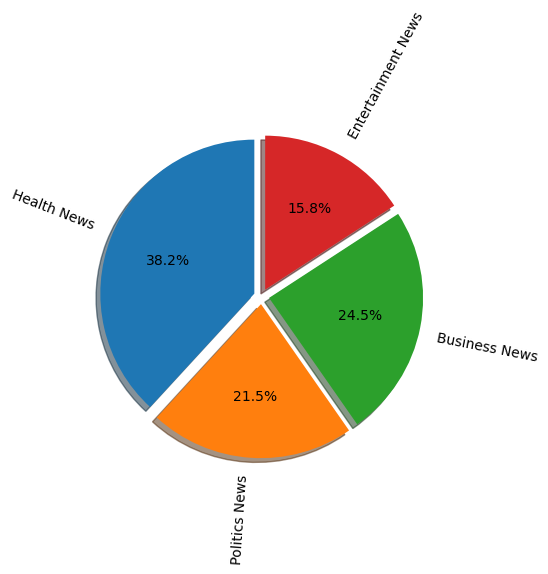

In [130]:
fig = plt.figure(figsize=(5, 5))
colors = ["skyblue"]
Health = dataset[dataset['CategoryId'] == 0]
Politics = dataset[dataset['CategoryId'] == 1]
Business = dataset[dataset['CategoryId'] == 2]
Entertainment = dataset[dataset['CategoryId'] == 3]
count = [Health['CategoryId'].count(), Politics['CategoryId'].count(), Business['CategoryId'].count(),
         Entertainment['CategoryId'].count()]
pie = plt.pie(count, labels=['Health News', 'Politics News', 'Business News', 'Entertainment News'],
              autopct="%1.1f%%",
              shadow=True,
              startangle=90,
              rotatelabels=45,
              explode=(0.05, 0.05, 0.05, 0.05))
plt.show()

Health related words:


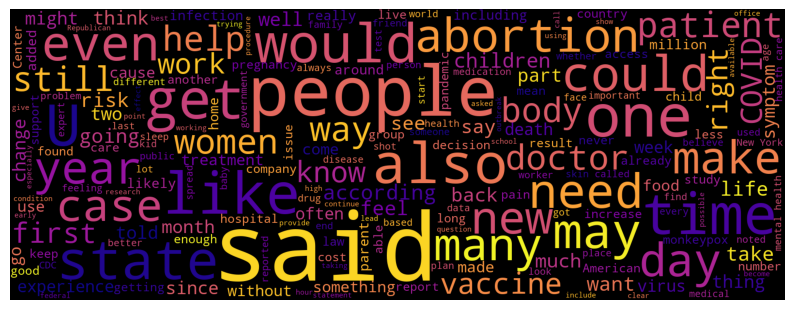

Politics related words:


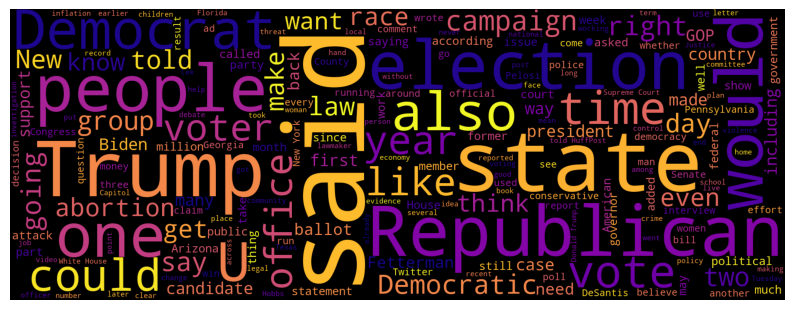

Business related words:


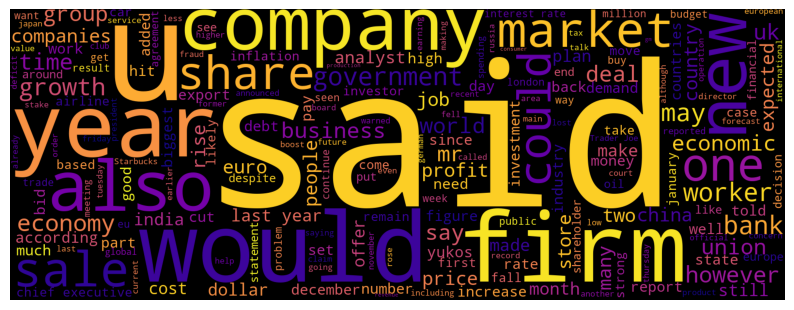

Entertainment related words:


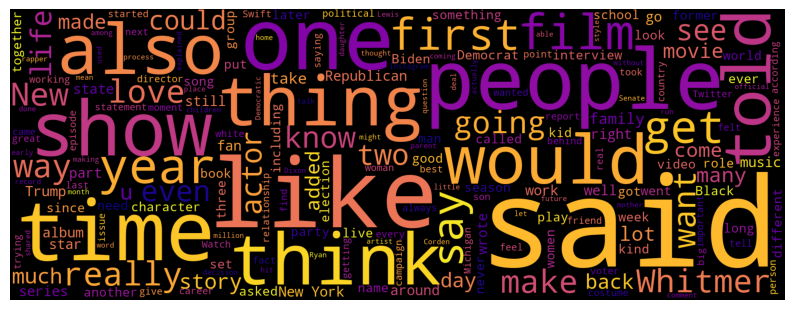

In [131]:
# Showing the wordcloud for each news category of the dataset set
stop = set(stopwords.words('english'))

Health = dataset[dataset['CategoryId'] == 0]['Text']
Politics = dataset[dataset['CategoryId'] == 1]['Text']
Business = dataset[dataset['CategoryId'] == 2]['Text']
Entertainment = dataset[dataset['CategoryId'] == 3]['Text']


def wordcloud_draw(dataset, color='black'):
    words = ' '.join(dataset)

    cleaned_word = ' '.join([word for word in words.split()

                             if (word != 'news' and word != 'text')])

    wordcloud = WordCloud(stopwords=stop,

                          background_color=color,

                          contour_color='black', colormap='plasma',

                          width=1600, height=600).generate(cleaned_word)

    plt.figure(1, figsize=(10, 7))

    plt.imshow(wordcloud)

    plt.axis("off")

    plt.show()


print("Health related words:")
wordcloud_draw(Health, 'black')

print("Politics related words:")
wordcloud_draw(Politics, 'black')

print("Business related words:")
wordcloud_draw(Business, 'black')

print("Entertainment related words:")
wordcloud_draw(Entertainment, 'black')

In [132]:
text = dataset["Text"]
text.head(10)

0    Changing the filter for your home s heating. v...
1    NASHVILLE. Tenn. (AP) — Tennessee s strict abo...
2    Work long enough. and you ll eventually face t...
3    AUSTIN. Texas (AP) — A Texas doctor said Thurs...
4    INDIANAPOLIS (AP) — An Indianapolis doctor who...
5    Monkeypoxreport presentedThe committee agreed ...
6    toll of opioidsTogether. the developments amou...
7    abortionThe study. which waspublished Tuesday ...
8    There s an old saying that adversity makes you...
9    After the debate between Pennsylvania Senate c...
Name: Text, dtype: object

In [133]:
category = dataset['Category']
category.head(10)

0    Health News
1    Health News
2    Health News
3    Health News
4    Health News
5    Health News
6    Health News
7    Health News
8    Health News
9    Health News
Name: Category, dtype: object

In [134]:
old_df = dataset.copy()
old_df['len_news'] = old_df['Text'].map(lambda x: len(x))
old_df.head()

,Text,Category,CategoryId,len_news
0,Changing the filter for your home s heating. v...,Health News,0,2701
1,NASHVILLE. Tenn. (AP) — Tennessee s strict abo...,Health News,0,2254
2,Work long enough. and you ll eventually face t...,Health News,0,1778
3,AUSTIN. Texas (AP) — A Texas doctor said Thurs...,Health News,0,2075
4,INDIANAPOLIS (AP) — An Indianapolis doctor who...,Health News,0,3301


# Data preprocessing

In [135]:
#remove all tag
def remove_tags(text):
    remove = re.compile(r'')
    return re.sub(remove, '', text)


dataset['Text'] = dataset['Text'].apply(remove_tags)

In [136]:
#Remove Special Characters
def special_char(text):
    reviews = ''
    for x in text:
        if x.isalnum():
            reviews = reviews + x
        else:
            reviews = reviews + ' '
    return reviews


dataset['Text'] = dataset['Text'].apply(special_char)

In [137]:
#Remove all Stopwords
def convert_lower(text):
    return text.lower()


dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][1]

'nashville  tenn   ap    tennessee s strict abortion ban does not apply to the disposal of fertilized human embryos that haven t been transferred to a uterus  according to a recent state attorney general opinion the determination is among the first issued by an attorney general that provides insight on how laws heavily restricting abortion affect those seeking in vitro fertilization  or ivf  since the u s  supreme court overturned the constitutional right to abortion  disposing of an embryo that was created outside a woman s body and that has never been transferred to a woman s body thus does not qualify as  abortion    jonathan skrmetti wrote in his opinion the two page document was quietly published on the attorney general s website on oct  20 at the request of tennessee s senate majority leader jack johnson  a republican currently seeking reelection tennessee s lawtrigger law while i felt that the law was clear and that it did not apply to this particular case and others like it  i 

In [138]:
# stopword
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]


dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][1]

['nashville',
 'tenn',
 'ap',
 'tennessee',
 'strict',
 'abortion',
 'ban',
 'apply',
 'disposal',
 'fertilized',
 'human',
 'embryos',
 'transferred',
 'uterus',
 'according',
 'recent',
 'state',
 'attorney',
 'general',
 'opinion',
 'determination',
 'among',
 'first',
 'issued',
 'attorney',
 'general',
 'provides',
 'insight',
 'laws',
 'heavily',
 'restricting',
 'abortion',
 'affect',
 'seeking',
 'vitro',
 'fertilization',
 'ivf',
 'since',
 'u',
 'supreme',
 'court',
 'overturned',
 'constitutional',
 'right',
 'abortion',
 'disposing',
 'embryo',
 'created',
 'outside',
 'woman',
 'body',
 'never',
 'transferred',
 'woman',
 'body',
 'thus',
 'qualify',
 'abortion',
 'jonathan',
 'skrmetti',
 'wrote',
 'opinion',
 'two',
 'page',
 'document',
 'quietly',
 'published',
 'attorney',
 'general',
 'website',
 'oct',
 '20',
 'request',
 'tennessee',
 'senate',
 'majority',
 'leader',
 'jack',
 'johnson',
 'republican',
 'currently',
 'seeking',
 'reelection',
 'tennessee',
 'lawtr

In [139]:
nltk.download('omw-1.4')


def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])


dataset['Text'] = dataset['Text'].apply(lemmatize_word)
dataset['Text'][1]

[nltk_data] Downloading package omw-1.4 to /home/bedge/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'nashville tenn ap tennessee strict abortion ban apply disposal fertilized human embryo transferred uterus according recent state attorney general opinion determination among first issued attorney general provides insight law heavily restricting abortion affect seeking vitro fertilization ivf since u supreme court overturned constitutional right abortion disposing embryo created outside woman body never transferred woman body thus qualify abortion jonathan skrmetti wrote opinion two page document quietly published attorney general website oct 20 request tennessee senate majority leader jack johnson republican currently seeking reelection tennessee lawtrigger law felt law clear apply particular case others like happy ask attorney general opinion clear perceived misunderstanding law pleased attorney general arrived conclusion johnson said skrmetti opinion clarifies disposal unused embryo remains unclear law applies selective reduction process sometimes used remove fetus woman womb fertil

In [140]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5000)
x = cv.fit_transform(dataset.Text).toarray()
y = np.array(dataset.CategoryId.values)
print("X.shape = ", x.shape)
print("y.shape = ", y.shape)

X.shape =  (1543, 5000)
y.shape =  (1543,)


In [141]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_valid, x_train = x_train[-40:, :], x_train[:-40, :]
y_valid, y_train = y_train[-40:], y_train[:-40]
print("Length of the training dataset:")
print("x:", len(x_train))
print("y:", len(x_train))
print("Length of the testing dataset:")
print("x:", len(x_test))
print("y:", len(y_test))
print("Length of the validation dataset:")
print("x:", len(x_valid))
print("y:", len(y_valid))


Length of the training dataset:
x: 1040
y: 1040
Length of the testing dataset:
x: 463
y: 463
Length of the validation dataset:
x: 40
y: 40


In [142]:
final_df = dataset.copy()
final_df['len_news'] = final_df['Text'].map(lambda x: len(x))
final_df.head()

,Text,Category,CategoryId,len_news
0,changing filter home heating ventilation air c...,Health News,0,1711
1,nashville tenn ap tennessee strict abortion ba...,Health News,0,1619
2,work long enough eventually face common pressu...,Health News,0,1314
3,austin texas ap texas doctor said thursday wor...,Health News,0,1457
4,indianapolis ap indianapolis doctor performed ...,Health News,0,2505


In [143]:
lenmax_df = final_df.groupby('Category')['len_news'].max().reset_index().sort_values(by='len_news', ascending=False)
print(lenmax_df.head())
print()
lenmin_df = final_df.groupby('Category')['len_news'].min().reset_index().sort_values(by='len_news', ascending=False)
print(lenmin_df.head())

             Category  len_news
1  Entertainment News     27816
2         Health News     24436
3       Politics News     18429
0       Business News      7166

             Category  len_news
3       Politics News        94
1  Entertainment News        84
0       Business News        81
2         Health News        21


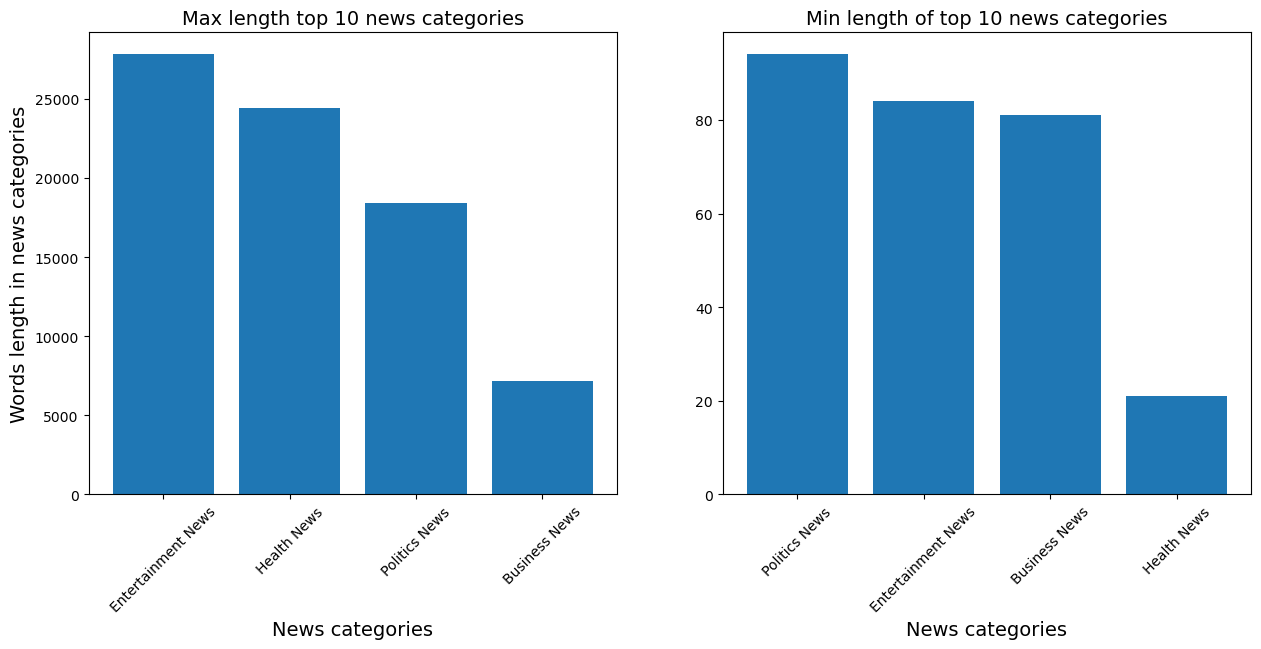

In [144]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.bar(lenmax_df['Category'][:10], lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories", size=14)
plt.text(6.5, 1400, '''       POLITICS HAS
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['Category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

In [145]:
old_length = old_df['Text'].apply(len).sum()
new_length = final_df['Text'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 4372252
New chracters length of text data: 2981600


In [146]:
old_text = old_df['Text'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = final_df['Text'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 732134
New word length of text data: 418626


In [147]:
#create list of model and accuracy dicts
perform_list = []

In [148]:
def run_model(use_model, model_name):
    mdl = use_model
    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')
    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'F1-score : {f1score}')
    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
    ]))

In [149]:
test_models = [
    {
        'model': LogisticRegression(),
        'name': "Logistic Regression"
    },
    {
        'model': RandomForestClassifier(
            n_estimators=400,
            random_state=0
        ),
        'name': "Random Forest"
    },
    {
        'model': MultinomialNB(
            alpha=1.0
            , fit_prior=True
        ),
        'name': "Multinomial Naive Bayes"
    },
    {
        'model': SVC(),
        'name': "Support Vector Classifier"
    },
    {
        'model': DecisionTreeClassifier(),
        'name': "Decision Tree Classifier"
    },
    {
        'model': KNeighborsClassifier(
            n_neighbors=10,
            metric='minkowski'
        ),
        'name': "K Nearest Neighbour"
    },
    {
        'model': GaussianNB(),
        'name': "Gaussian Naive Bayes"
    },
]
for test_model in test_models:
    classifier, name = test_model.values()
    run_model(classifier, name)

/home/bedge/anaconda3/envs/aiml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bedge/anaconda3/envs/aiml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Test Accuracy Score of Basic Logistic Regression: % 80.78
Precision : 0.8077753779697624
Recall : 0.8077753779697624
F1-score : 0.8077753779697624
Test Accuracy Score of Basic Random Forest: % 82.51
Precision : 0.8250539956803455
Recall : 0.8250539956803455
F1-score : 0.8250539956803455
Test Accuracy Score of Basic Multinomial Naive Bayes: % 83.59
Precision : 0.8358531317494601
Recall : 0.8358531317494601
F1-score : 0.8358531317494601
Test Accuracy Score of Basic Support Vector Classifier: % 79.27
Precision : 0.7926565874730022
Recall : 0.7926565874730022
F1-score : 0.7926565874730022
Test Accuracy Score of Basic Decision Tree Classifier: % 63.28
Precision : 0.6328293736501079
Recall : 0.6328293736501079
F1-score : 0.6328293736501079
Test Accuracy Score of Basic K Nearest Neighbour: % 45.57
Precision : 0.4557235421166307
Recall : 0.4557235421166307
F1-score : 0.45572354211663074
Test Accuracy Score of Basic Gaussian Naive Bayes: % 64.58
Precision : 0.6457883369330454
Recall : 0.6457883

In [150]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance
model = model_performance["Model"]
max_index = model_performance["Test Accuracy"].idxmax()

print(
    "The best accuracy of model is",
    model_performance['Test Accuracy'][max_index],
    "from",
    model_performance['Model'][max_index])

The best accuracy of model is 83.59 from Multinomial Naive Bayes


In [151]:
import joblib

classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0).fit(x_train, y_train)
joblib.dump(classifier, '4514Model.pkl')
joblib.dump(cv, 'cv.pkl')

['cv.pkl']

In [152]:
y_pred1 = cv.transform([
    'Hour ago, I contemplated retirement for a lot of reasons. I felt like people were not sensitive enough to my injuries. I felt like a lot of people were backed, why not me? I have done no less. I have won a lot of games for the team, and I am not feeling backed, said Ashwin'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
    result = "Health News"
elif yy == [1]:
    result = "Politics News"
elif yy == [2]:
    result = "Business News"
elif yy == [3]:
    result = "Entertainment News"

print(result)

Entertainment News


In [153]:
y_pred1 = cv.transform([
    'The world behind the on-screen magic is once again thrown into light in Behind Every Star, the Korean remake of the popular French behind-the-stars drama Call My Agent!.'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
    result = "Health News"
elif yy == [1]:
    result = "Politics News"
elif yy == [2]:
    result = "Business News"
elif yy == [3]:
    result = "Entertainment News"

print(result)

Politics News


In [154]:
y_pred1 = cv.transform([
    'In most people, norovirus causes a few days of misery spent in the bathroom and then is quickly forgotten. Epstein-Barr virus can pass without any indication at all. And many people shrug off Covid-19.'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
    result = "Health News"
elif yy == [1]:
    result = "Politics News"
elif yy == [2]:
    result = "Business News"
elif yy == [3]:
    result = "Entertainment News"

print(result)

Health News


# Predicting local news


In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
local_news_y_pred = classifier.predict(x_valid)

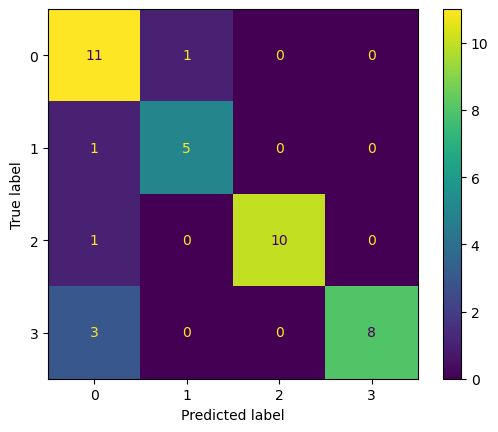

In [156]:
cm = confusion_matrix(y_valid, local_news_y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()


In [158]:
print(f"Accuracy of the Random forest classifier is: {round(accuracy_score(y_valid, local_news_y_pred), 2)}")


Accuracy of the Random forest classifier is: 0.85
